<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Токенизация-и-лемматизация" data-toc-modified-id="Токенизация-и-лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Токенизация и лемматизация</a></span></li><li><span><a href="#Стоп---слова" data-toc-modified-id="Стоп---слова-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Стоп - слова</a></span></li><li><span><a href="#Несбалансированная-классификация" data-toc-modified-id="Несбалансированная-классификация-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Несбалансированная классификация</a></span></li><li><span><a href="#Разбивка-выборок" data-toc-modified-id="Разбивка-выборок-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Разбивка выборок</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#MultinomialNB" data-toc-modified-id="MultinomialNB-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>MultinomialNB</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>SGDClassifier</a></span></li><li><span><a href="#Результаты" data-toc-modified-id="Результаты-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Результаты</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import spacy
import re

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score,  roc_curve


from tqdm import tqdm
tqdm.pandas()

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Загрузка данных

In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


В распоряжении данные с комментариями и разметкой токсичности. Токсичные комментарии размеченны "1". 

Посмотрим на базовую информацию.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Пропусков нет. В данных почти 160 тыс. постов.

Разобьем твиты на отдельные слова и символы (токенизация) и приведем к начальной форме слова (лемматизация).

### Токенизация и лемматизация

Сначала очистим текст от знаков пунктуации и других лишних символом.

In [6]:
def tokenization(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return " ".join(text.split())

In [7]:
data['text'] = data['text'].apply(tokenization)

Для дальнейшем обработки текста воспользуемся пайплайном из библиотеки spaCy.

In [8]:
nlp = spacy.load("en_core_web_sm")

In [9]:
lemm_texts = []

for doc in tqdm(nlp.pipe(data['text'].values, disable = ['ner', 'parser']), total=data.shape[0]):
    lemm_text = " ".join([i.lemma_ for i in doc])    
    lemm_texts.append(lemm_text)

100%|██████████| 159292/159292 [08:06<00:00, 327.30it/s]


In [10]:
data['text'] = lemm_texts

In [11]:
#check
data.head()

,Unnamed: 0,text,toxic
0,0,explanation why the edit make under my usernam...,0
1,1,d aww he match this background colour I m seem...,0
2,2,hey man I m really not try to edit war it s ju...,0
3,3,More I can t make any real suggestion on impro...,0
4,4,you sir be my hero any chance you remember wha...,0


Удалены знаки пунктуации, буквы приведены к нижнему регистру и слова в начальную форму.

In [12]:
# удалим ненужный столбец Unnamed:0
data = data.drop(['Unnamed: 0'], axis=1)

In [13]:
#check
data.head()

,text,toxic
0,explanation why the edit make under my usernam...,0
1,d aww he match this background colour I m seem...,0
2,hey man I m really not try to edit war it s ju...,0
3,More I can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


### Стоп - слова

Избавимся от стоп - слов с помощью библиотеки sklearn. В английском языке к ним относятся артикли “a” “the” “is” “are” и др., которые очень часто используются.

In [14]:
stopwords = list(set(nltk_stopwords.words('english')))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [15]:
count_tf_idf

TfidfVectorizer(stop_words=['any', 'into', "won't", 'hasn', 'what', 'wouldn',
                            'over', "wouldn't", 'more', 'here', "she's", 'she',
                            'after', 's', 'just', 'down', 't', 'between',
                            'being', 'other', 'of', 'very', 'ain', 'who', 'on',
                            'our', 'ma', 'were', 'me', 'had', ...])

### Несбалансированная классификация

Перед нами стоит задача бинарной классификации. Посмотрим как распределны метки.

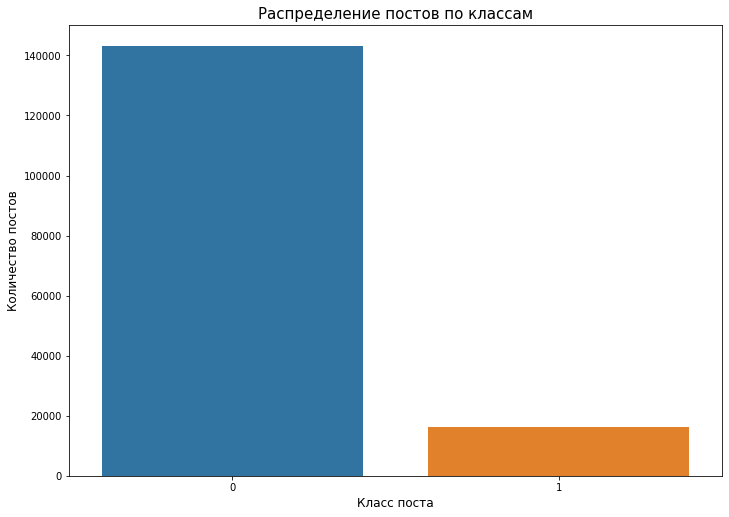

In [16]:
fig, axs = plt.subplots(figsize=(11.7, 8.3))
sns.countplot(x=data.toxic);

plt.ylabel('Количество постов', fontsize=12);
plt.xlabel('Класс поста', fontsize=12);
plt.title('Распределение постов по классам', fontsize=15);

Как видно из графика, количество постов с разметкой `1` примерно в 7 раз меньше, чем количество постов с разметкой `0`. Для решения этой проблемы есть несколько вариантов действий:

1. Взвешивание классов - то есть, придание объектам класса `1` больший вес (обычно через аргумент `class_weight` у моделей из библиотеки sklearn)

2. Увеличение выборки (upsampling) - то есть, скопировать несколько раз объекты редкого класса, чтобы уравновесить выборку и перемещать.

3. Уменьшение выборки (downsampling) - то есть, удалить случайным образом объекты большего класса и перемещать.

4. Изменить порог классификации - для модели логистической регрессии можно изменять "точку отсечения" класса.

В дальнейшем будет применяться первый метод, если результаты будут неудовлетворительными, то проверим другие.

### Разбивка выборок

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['toxic'], test_size=0.1, random_state=42)

In [18]:
#check
dfs = [X_train, X_test, y_train, y_test]
for df in dfs:
    print(df.shape)

(143362,)
(15930,)
(143362,)
(15930,)


Выборки разделены.

### Вывод

В ходе предобработки данных были выполнены следующие шаги:

1. Токенизация.
2. Лемматизация.
3. Выявлена проблема дисбаланса класса.
4. Выборка разделена на обучающую и тестовую в соотношении 70:30.

Далее проверим метрики моделей на обучающей выборке.

## Обучение

В рамках исследования будут применяться три модели машинного обучения из библиотеки sklearn:

1. Логистическая регрессия (`LogisticRegression`).
2. Наивный байесовский классификатор (`MultinomialNB`).
3. Стохастический градиентный спуск (`SGDClassifier`).

Обучение будет состоять из следующих шагов:

1. Векторизация текста с удалением стоп-слов (`TfidfVectorizer`).
2. Задание классификатора и начальных параметров.
3. Подбор гиперпараметров для векторизации и классификатора с кросс-валидацией по F1 метрике.

Так как данные достаточно сильно несбалансированны воспользуемся `StratifiedKFold`. Выборки будут разбиты на фолды с примерно таким же распределением классов, как и для всего множества.

In [19]:
cross_val = StratifiedKFold(n_splits=5)

### Logistic Regression

In [20]:
pipeline_lr = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", LogisticRegression(class_weight='balanced', solver='liblinear')),
    ]
)

In [21]:
#check
pipeline_lr

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['any', 'into', "won't", 'hasn',
                                             'what', 'wouldn', 'over',
                                             "wouldn't", 'more', 'here',
                                             "she's", 'she', 'after', 's',
                                             'just', 'down', 't', 'between',
                                             'being', 'other', 'of', 'very',
                                             'ain', 'who', 'on', 'our', 'ma',
                                             'were', 'me', 'had', ...])),
                ('clf',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])

In [22]:
parameter_grid_lr = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),
    "clf__penalty":('l1', 'l2'),
    "clf__C":[0.001, 0.01, 0.1, 1, 10],
    "clf__max_iter":range(100, 500, 25),
    "clf__tol": [1e-5, 1e-6, 1e-4]
}

In [23]:
random_search_lr = RandomizedSearchCV(
    estimator=pipeline_lr,
    param_distributions=parameter_grid_lr,
    n_iter=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    scoring='f1',
    cv=cross_val
)

In [24]:
random_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words=['any',
                                                                          'into',
                                                                          "won't",
                                                                          'hasn',
                                                                          'what',
                                                                          'wouldn',
                                                                          'over',
                                                                          "wouldn't",
                                                                          'more',
                                                                          'here',
                                   

In [25]:
best_parameters_lr = random_search_lr.best_estimator_.get_params()
print('Лучшее значение метрики:', random_search_lr.best_score_.round(3))

Лучшее значение метрики: 0.78


### MultinomialNB

In [26]:
pipeline_nb = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", MultinomialNB()),
    ]
)

In [27]:
#check
pipeline_nb

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['any', 'into', "won't", 'hasn',
                                             'what', 'wouldn', 'over',
                                             "wouldn't", 'more', 'here',
                                             "she's", 'she', 'after', 's',
                                             'just', 'down', 't', 'between',
                                             'being', 'other', 'of', 'very',
                                             'ain', 'who', 'on', 'our', 'ma',
                                             'were', 'me', 'had', ...])),
                ('clf', MultinomialNB())])

In [28]:
parameter_grid_nb = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),
    "vect__norm": ("l1", "l2"),
    "clf__alpha": np.logspace(-6, 6, 13)
}

In [29]:
random_search_nb = RandomizedSearchCV(
    estimator=pipeline_nb,
    param_distributions=parameter_grid_nb,
    n_iter=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    scoring='f1',
    cv=cross_val
)

In [30]:
%%time
random_search_nb.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: user 3min 51s, sys: 5.95 s, total: 3min 57s
Wall time: 3min 57s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words=['any',
                                                                          'into',
                                                                          "won't",
                                                                          'hasn',
                                                                          'what',
                                                                          'wouldn',
                                                                          'over',
                                                                          "wouldn't",
                                                                          'more',
                                                                          'here',
                                   

In [31]:
best_parameters_nb = random_search_nb.best_estimator_.get_params()
print('Лучшее значение метрики:', random_search_nb.best_score_.round(3))

Лучшее значение метрики: 0.666


### SGDClassifier

In [32]:
pipeline_sgdc = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stopwords)),
        ("clf", SGDClassifier(loss='hinge', penalty='l2',   random_state=42, learning_rate='optimal')),
    ]
)

In [33]:
parameter_grid_sgdc = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),
    'clf__max_iter':range(1000, 2000, 100),
    'clf__alpha': np.logspace(-6, 6, 13) 
}

In [34]:
random_search_sgdc = RandomizedSearchCV(
    estimator=pipeline_sgdc,
    param_distributions=parameter_grid_sgdc,
    n_iter=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    scoring='f1',
    cv=cross_val
)

In [35]:
%%time
random_search_sgdc.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: user 2min 38s, sys: 4.41 s, total: 2min 43s
Wall time: 2min 44s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words=['any',
                                                                          'into',
                                                                          "won't",
                                                                          'hasn',
                                                                          'what',
                                                                          'wouldn',
                                                                          'over',
                                                                          "wouldn't",
                                                                          'more',
                                                                          'here',
                                   

In [36]:
best_parameters_sgdc = random_search_sgdc.best_estimator_.get_params()
print('Лучшее значение метрики:', random_search_sgdc.best_score_.round(3))

Лучшее значение метрики: 0.772


### Результаты

In [37]:
result = pd.DataFrame(
    {
        'Модель': ['LogisticRegression', 'MultinomialNB', 'SGDClassifier'],
        'F1 метрика':[random_search_lr.best_score_.round(3), 
                      random_search_nb.best_score_.round(3), 
                      random_search_sgdc.best_score_.round(3)]
    }
)
result

,Модель,F1 метрика
0,LogisticRegression,0.780
1,MultinomialNB,0.666
2,SGDClassifier,0.772


Лучший результат у модели `LogisticRegression`. Используем ее для тестовой выборки с уже подобранными гиперпараметрами.

## Тестирование

In [38]:
predictions = random_search_lr.predict(X_test)
f1score = f1_score(y_test, predictions)
print('Значение метрики на тестовой выборке:', f1score.round(3))

Значение метрики на тестовой выборке: 0.797


Так же проверим насколько сильно отличается эта модель от случайной с помощью кривой ошибок.

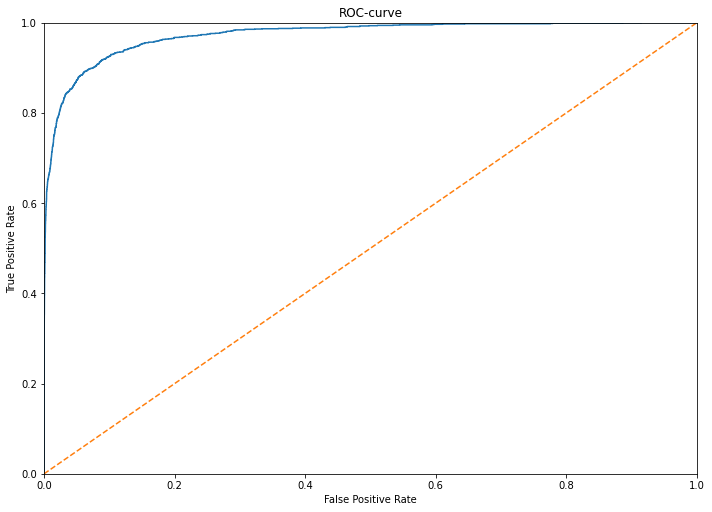

0.972477137594296

In [39]:
probabilities_test = random_search_lr.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test) 

plt.figure(figsize=(11.7, 8.3))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

roc_auc = roc_auc_score(y_test, probabilities_one_test)

roc_auc

Модель намного лучше чем случайная модель.

## Выводы

В ходе подготовки данных проделали следующие шаги:


1. Подготовили данные, проведя токенизацию и лемматизацию постов. Так же удалили ненужный столбец из данных.
2. Выявили проблему несбалансированной классификации.
3. Загрузили список стоп-слов.
4. Разбили выборки на обучающую и тестовую.

Было решено первоначально воспользоваться встроенными параметрами моделей машинного обучения для несбалансированных данных. Этого оказалось достаточно и модели справились с проблемой дисбаланса.

Перед обучением выборку разбили на фолды с примерно таким же распределением классов, что и у всего множества.

Обучение проводили в несколько шагов:

1. Подбор гиперпараметров для векторизатора текста.
2. Подбор гиперпараметров для классификатора.
3. Обучение и определение значения метрики на кросс-валидации.

По итогам лучший результат показала модель логистической регрессии. Ее и использовали для тестовой выборки. На тестовой выборке получили требуемое значение метрики.